# Calculating Betas for the Market's Stocks #

### Calculating the Betas for all the Stocks in the Universe ###

In [4]:
# Import Libraries

# Data Management
import pandas as pd
import numpy as np

# Plots
import matplotlib.pyplot as plt

# Statistics
import statsmodels.api as sm
from scipy.optimize import minimize
from scipy.stats import norm

# Manipulate Files
import os

# Pretty Notation
from IPython.display import display, Math

In [5]:
# Get the important data for the Risk Free Rate

rfr = pd.read_csv(rf"..\additional_data\rfr.csv")
rfr = rfr.set_index('Date')
rfr.index = pd.to_datetime(rfr.index, dayfirst=True)
rfr.dropna(inplace = True)

# Get the important data for the S&P500

sp500 = pd.read_csv(rf"..\additional_data\sp500.csv")
sp500 = sp500.set_index('Date')
sp500.index = pd.to_datetime(sp500.index)

In [6]:
# Create the Weights function
def wexp(N, half_life):
    c = np.log(0.5)/half_life
    n = np.array(range(N))
    w = np.exp(c*n)
    return np.flip(w/np.sum(w))

# Create the CAPM 
def CAPM(
    stock_prices: pd.Series, 
    benchmark_prices: pd.Series = sp500['sp_500'], 
    risk_free_rate: pd.Series = rfr['risk_free_rate'], 
    window: int = 252,
    WLS: bool = True,
):

    # Align time series to the same date range
    common_index = stock_prices.index.intersection(benchmark_prices.index).intersection(risk_free_rate.index)
    stock_prices = stock_prices.loc[common_index]
    benchmark_prices = benchmark_prices.loc[common_index]
    risk_free_rate = risk_free_rate.loc[common_index]
    
    # Compute daily returns
    stock_returns = stock_prices.pct_change(1)
    benchmark_returns = benchmark_prices.pct_change(1)
    risk_free_daily = (((1 + (risk_free_rate.div(100)))**(1/360)) - 1)  # Convert annual rate to daily
    
    # Excess returns
    excess_stock = stock_returns - risk_free_daily
    excess_benchmark = benchmark_returns - risk_free_daily

    alphas, betas = [], []

    # Create weights with exponential decay
    weights = window * wexp(window, window/2)
    
    for t in range(window, len(stock_returns)):
        X = excess_benchmark.iloc[t-window:t]
        y = excess_stock.iloc[t-window:t]
        
        if X.isnull().any() or y.isnull().any():
            continue

        if WLS:
            
            # Fit WLS regression
            model = sm.WLS(y, sm.add_constant(X), weights=weights, missing='drop').fit()

        else:

            # Fit OLS regression
            model = sm.OLS(y, sm.add_constant(X), missing='drop').fit()

        # Avoid KeyError by checking if params exist
        params = model.params
        
        alphas.append(params.iloc[0])
        betas.append(params.iloc[1])
            
    parameters = pd.DataFrame({
        'alpha': alphas,
        'beta': betas,
    }, index=stock_returns.index[window+1:])
    
    return parameters

In [7]:
# Dictionary to store the DataFrames
folder_path = r"..\stocks"

dataframes = {} 

# List all files in the folder
for file in os.listdir(folder_path):
    if file.endswith(".csv"):
        # Full path to the file
        file_path = os.path.join(folder_path, file)
        
        # Read the Excel file
        df = pd.read_csv(file_path)
        df = df.set_index("Date")
        df.index = pd.to_datetime(df.index)

        df = df['Adjusted_close']

        df = df.rename("adj_close")
        
        # Fill nans
        df = df.interpolate(method='time')

        df = df.loc['2015-01-01':]

        df.dropna(inplace=True)
        
        if len(df) >= 2000:
            # File name without extension
            file_name = os.path.splitext(file)[0]
            
            # Guardar en el diccionario
            dataframes[file_name] = df
            print(f"File loaded: {file_name} ({len(df)} rows)")
        else:
            print(f"File skipped (less than 2000 rows after cleaning): {file}")

print(f"\nTotal files loaded: {len(dataframes)}")
print("Files loaded:", list(dataframes.keys()))

File loaded: A (2472 rows)
File loaded: AAPL (2472 rows)
File loaded: ABBV (2472 rows)
File skipped (less than 2000 rows after cleaning): ABNB.csv
File loaded: ABT (2472 rows)
File loaded: ADBE (2472 rows)
File loaded: ADI (2472 rows)
File loaded: ADM (2472 rows)
File loaded: ADP (2472 rows)
File loaded: ADSK (2472 rows)
File loaded: AEE (2472 rows)
File loaded: AEP (2472 rows)
File loaded: AES (2472 rows)
File loaded: AFL (2472 rows)
File loaded: AIG (2472 rows)
File loaded: AIZ (2472 rows)
File loaded: AJG (2472 rows)
File loaded: AKAM (2472 rows)
File loaded: ALB (2472 rows)
File loaded: ALGN (2472 rows)
File loaded: ALL (2472 rows)
File loaded: AMAT (2472 rows)
File loaded: AMD (2472 rows)
File loaded: AME (2472 rows)
File loaded: AMGN (2472 rows)
File loaded: AMP (2472 rows)
File loaded: AMT (2472 rows)
File loaded: AMZN (2472 rows)
File loaded: ANET (2472 rows)
File loaded: ANSS (2472 rows)
File loaded: AOS (2472 rows)
File loaded: APA (2472 rows)
File loaded: APD (2472 rows)
Fil

In [8]:
# Let us obtain the betas of each stock

betas_dict = {}

# Create the Loop to Obtain the Betas
for ticker in dataframes.keys():
    df = CAPM(dataframes[ticker])
    betas_dict[ticker] = df['beta']

    print(f'{ticker} is ready.')

A is ready.
AAPL is ready.
ABBV is ready.
ABT is ready.
ADBE is ready.
ADI is ready.
ADM is ready.
ADP is ready.
ADSK is ready.
AEE is ready.
AEP is ready.
AES is ready.
AFL is ready.
AIG is ready.
AIZ is ready.
AJG is ready.
AKAM is ready.
ALB is ready.
ALGN is ready.
ALL is ready.
AMAT is ready.
AMD is ready.
AME is ready.
AMGN is ready.
AMP is ready.
AMT is ready.
AMZN is ready.
ANET is ready.
ANSS is ready.
AOS is ready.
APA is ready.
APD is ready.
APH is ready.
APO is ready.
ARE is ready.
AWK is ready.
BALL is ready.
BDX is ready.
BK is ready.
BKNG is ready.
BLDR is ready.
BMY is ready.
BR is ready.
BRO is ready.
BSX is ready.
BWA is ready.
BX is ready.
BXP is ready.
C is ready.
CAG is ready.
CAH is ready.
CBRE is ready.
CCI is ready.
CDNS is ready.
CDW is ready.
CE is ready.
CF is ready.
CFG is ready.
CHD is ready.
CHRW is ready.
CHTR is ready.
CI is ready.
CINF is ready.
CL is ready.
CLX is ready.
CMCSA is ready.
CME is ready.
CMG is ready.
CMI is ready.
CMS is ready.
CNC is rea

In [9]:
# Create the DataFrame
betas_df = pd.DataFrame.from_dict(betas_dict)
betas_df = betas_df.apply(lambda x: x.fillna(x.mean()), axis=0)

betas_df

,A,AAPL,ABBV,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WST,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-08,1.169801,1.147189,1.020613,1.204812,0.999815,1.243746,0.981288,1.049395,1.009929,0.559332,...,0.856893,0.937214,1.708455,0.531819,1.064428,1.007787,1.002596,0.821984,1.494902,1.020760
2016-01-11,1.167770,1.135761,1.032587,1.210169,1.001209,1.238406,0.974001,1.047316,1.012501,0.559818,...,0.856111,0.937283,1.721904,0.537210,1.071017,1.007377,1.003930,0.818455,1.485398,1.023555
2016-01-12,1.166375,1.136806,1.024002,1.211396,1.003453,1.241084,0.972430,1.048343,1.015570,0.559591,...,0.854448,0.937870,1.718190,0.537422,1.070249,1.007402,0.999302,0.813795,1.482889,1.019380
2016-01-13,1.162057,1.134450,1.032051,1.216526,0.999187,1.242375,0.980352,1.049293,1.004531,0.557271,...,0.857982,0.923881,1.705672,0.532184,1.077893,1.009344,1.007880,0.828707,1.487805,1.020597
2016-01-14,1.172151,1.130829,1.095173,1.213185,0.987322,1.241761,0.976254,1.050547,1.079909,0.543485,...,0.830912,0.902395,1.727706,0.520218,1.025449,1.009536,0.980446,0.820496,1.519260,1.043191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-22,0.876024,1.037784,0.194116,0.161045,1.152206,1.811336,0.440483,0.369979,1.321823,0.050615,...,0.659139,0.629752,0.945839,0.030220,0.178951,1.048215,0.402963,0.558583,1.298215,0.644560
2024-10-23,0.885034,1.040036,0.185126,0.162425,1.155704,1.812294,0.440543,0.368008,1.320912,0.048642,...,0.657083,0.631516,0.950898,0.028141,0.178514,1.057987,0.403819,0.558005,1.297213,0.643499
2024-10-24,0.882041,1.054079,0.192155,0.158307,1.156394,1.783464,0.423049,0.364567,1.315633,0.022642,...,0.645426,0.618673,0.963019,0.010037,0.175143,1.046621,0.393233,0.547803,1.299909,0.640561


In [10]:
# Save the betas

betas_df.to_csv(r"..\additional_data\betas.csv")

In [11]:
# Create the Returns DataFrame
returns_dict = {}

# Create the Loop to Obtain the Betas
for ticker in dataframes.keys():
    df = dataframes[ticker].pct_change(1).dropna()
    returns_dict[ticker] = df

# Create the DataFrame
df_returns = pd.DataFrame.from_dict(returns_dict)
df_returns = df_returns.apply(lambda x: x.fillna(x.mean()), axis=0)

df_returns

,A,AAPL,ABBV,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WST,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-05,-0.018738,-0.028172,-0.018819,0.000223,-0.004976,-0.018275,-0.034602,-0.000720,-0.014614,-0.010002,...,-0.013804,0.000000,-0.017020,-0.011351,-0.027362,-0.062237,-0.020318,0.037303,-0.014077,-0.006003
2015-01-06,-0.015578,0.000094,-0.004950,-0.011356,-0.020144,-0.023384,-0.019713,-0.008350,-0.019775,-0.011641,...,-0.017107,-0.001108,-0.021331,0.005321,-0.005316,-0.005881,-0.012274,-0.008477,-0.007205,-0.009756
2015-01-07,0.013272,0.014022,0.040417,0.008108,0.008223,0.010516,0.015031,0.008784,-0.002087,0.007778,...,0.016218,0.003050,0.029368,0.008635,0.010133,0.007887,0.033138,0.024870,0.025465,0.020643
2015-01-08,0.029975,0.038422,0.010459,0.020554,0.025383,0.017655,-0.014609,0.022940,0.024747,0.003528,...,0.019657,0.010779,0.012031,0.011599,0.016645,0.007546,0.017420,0.010617,0.021359,0.015399
2015-01-09,-0.007337,0.001072,-0.027355,-0.010508,-0.014743,-0.000730,-0.008530,-0.007162,-0.009014,-0.011206,...,-0.011453,-0.001367,0.012499,-0.012285,-0.001410,-0.018863,-0.001767,-0.014424,0.014613,0.001584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-22,-0.024130,-0.002622,0.011901,-0.007437,-0.009242,-0.004653,-0.007839,0.001478,-0.004486,-0.005327,...,-0.002959,-0.019820,0.010471,0.003941,0.005163,-0.008678,-0.004776,-0.008935,-0.001584,0.000317
2024-10-23,-0.003222,-0.021623,-0.004662,0.007664,-0.016386,0.009928,0.007003,-0.004462,-0.007574,0.016408,...,0.000140,0.006319,-0.017304,0.010050,-0.003563,0.002664,0.004949,0.004220,-0.010511,-0.002744
2024-10-24,-0.017590,-0.000823,0.009421,-0.004017,-0.004453,0.012475,0.007489,-0.002103,-0.001834,-0.002130,...,0.154343,0.008791,0.002252,0.012282,-0.005654,-0.008123,-0.006417,-0.006686,-0.016409,-0.039632


In [12]:
# Calculate the Whole Story Betas

# Create useful series
risk_free_daily = (((1 + (rfr['risk_free_rate'].div(100)))**(1/360)) - 1)
market_returns = sp500['sp_500'].pct_change(1).dropna()

# Common Indexes
common_index = df_returns.index.intersection(risk_free_daily.index).intersection(market_returns.index)
df_returns, risk_free_daily, market_returns = df_returns.loc[common_index], risk_free_daily.loc[common_index], market_returns.loc[common_index]

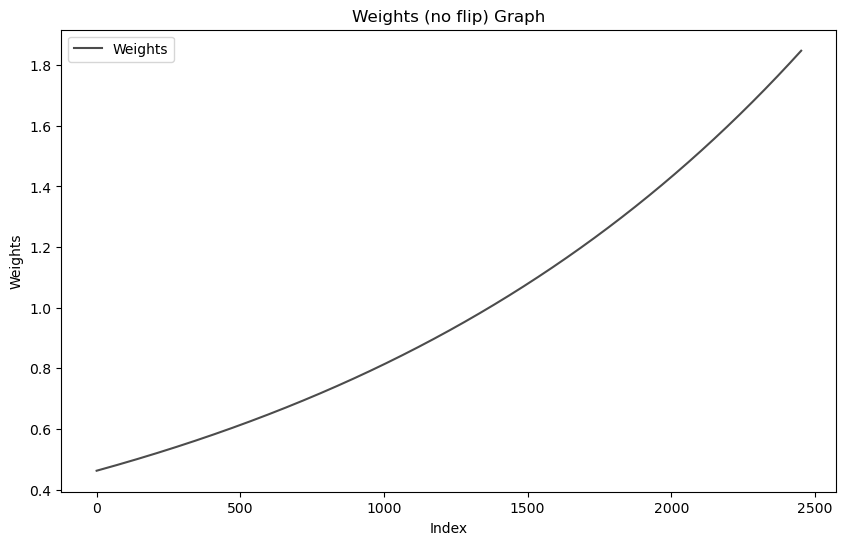

In [13]:
# Create Weights
window = len(df_returns)
weights = window * wexp(window, window/2)

plt.figure(figsize=(10, 6))
plt.plot(weights, label='Weights', color='black', alpha=0.7)

# Config
plt.title('Weights (no flip) Graph')
plt.xlabel('Index')
plt.ylabel('Weights')
plt.legend()

# Show
plt.show()

In [14]:
# Create the Historical Betas and Alpha + Residuals DataFrames
betas_dict = {}
alpha_resids_df = pd.DataFrame(index=df_returns.index)

# Loop to Obtain Betas and Alpha + Residuals
for ticker in df_returns.columns:
    df = pd.DataFrame()
    df['y'] = df_returns[ticker] - risk_free_daily
    df['x'] = market_returns - risk_free_daily

    # Drop NaNs
    df = df.dropna()

    # Add constant (alpha term)
    X = sm.add_constant(df['x'])
    y = df['y']

    # Fit the WLS model
    model = sm.WLS(y, X, weights=weights, missing='drop').fit()

    # Extract Alpha and Beta
    alpha = model.params['const']
    beta = model.params['x']

    # Store Beta
    betas_dict[ticker] = beta

    # Compute (Alpha + Residuals)
    alpha_residuals = model.resid + alpha  # Add alpha to residuals

    # Store Alpha + Residuals
    alpha_resids_df = pd.concat([alpha_resids_df, alpha_residuals.rename(ticker)], axis=1)

# Create Beta Series
betas_series = pd.Series(betas_dict)

betas_series

A       1.005530
AAPL    1.199206
ABBV    0.598485
ABT     0.798042
ADBE    1.296587
          ...   
XYL     1.069749
YUM     0.759770
ZBH     0.860327
ZBRA    1.350831
ZTS     0.928944
Length: 399, dtype: float64

In [15]:
alpha_resids_df

,A,AAPL,ABBV,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WST,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-06,-0.006635,0.010770,0.000351,-0.004270,-0.008597,-0.011908,-0.012802,0.000224,-0.007327,-0.006571,...,-0.009398,0.009752,-0.008986,0.010078,0.001852,0.003637,-0.005530,-0.000833,0.004828,-0.001498
2015-01-07,0.001578,0.000086,0.033435,-0.001184,-0.006840,-0.004455,0.005966,-0.002432,-0.018316,0.001095,...,0.006121,-0.011124,0.013272,0.002356,0.000735,-0.004550,0.024289,0.014857,0.009774,0.009835
2015-01-08,0.011988,0.016982,-0.000270,0.006267,0.002206,-0.005381,-0.028547,0.005689,-0.000226,-0.006739,...,0.004129,-0.011027,-0.012737,0.001954,0.002195,-0.011586,0.003816,-0.004781,-0.002786,-0.001222
2015-01-09,0.001114,0.011161,-0.022347,-0.003812,-0.003831,0.010115,-0.001999,0.000940,0.002751,-0.006418,...,-0.004168,0.008895,0.024166,-0.007791,0.005363,-0.009869,0.004605,-0.007201,0.025984,0.009387
2015-01-12,-0.003687,-0.014924,0.004519,0.014856,0.000488,0.000394,-0.006206,0.002895,-0.005488,0.000612,...,0.008753,0.011253,0.007278,-0.004517,-0.012696,-0.013108,-0.001350,0.009324,0.012442,-0.011242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-22,-0.023652,-0.002030,0.012139,-0.007081,-0.008593,-0.004008,-0.007495,0.001932,-0.003777,-0.005104,...,-0.002562,-0.019216,0.011173,0.004144,0.005524,-0.008162,-0.004443,-0.008543,-0.000902,0.000750
2024-10-23,0.006021,-0.010578,0.000793,0.014976,-0.004434,0.021806,0.014133,0.004397,0.005315,0.021622,...,0.008099,0.017556,-0.004522,0.014939,0.003834,0.012505,0.011905,0.012112,0.001946,0.005786
2024-10-24,-0.019747,-0.003374,0.008091,-0.005752,-0.007202,0.009743,0.005793,-0.004176,-0.004787,-0.003408,...,0.152466,0.006199,-0.000677,0.011076,-0.007408,-0.010411,-0.008075,-0.008548,-0.019267,-0.041633


In [16]:
# Save the betas
alpha_resids_df.to_csv(r"..\additional_data\capm_residuals.csv")
betas_series.to_csv(r"..\additional_data\historical_betas.csv")

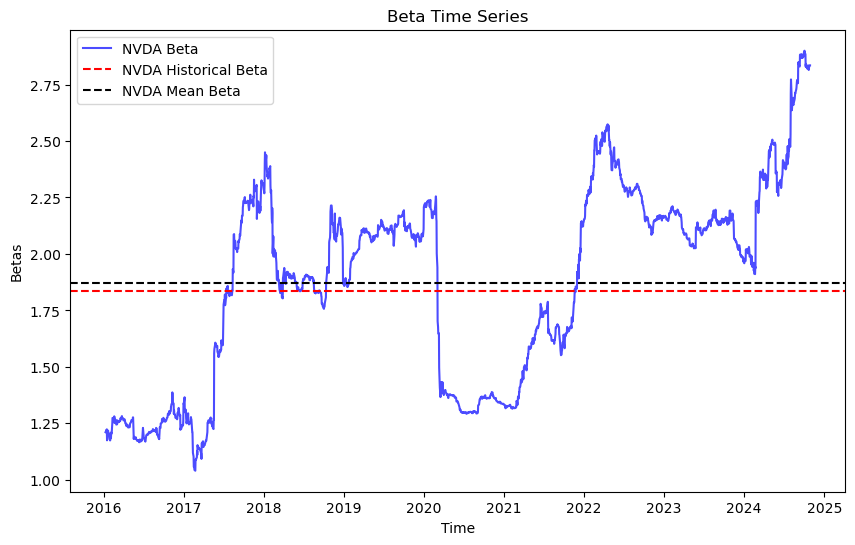

In [17]:
# Plot
ticker = 'NVDA'

# Mean
mean = betas_df[ticker].mean()

# Create the Plot
plt.figure(figsize=(10, 6))
plt.plot(betas_df[ticker], label=f'{ticker} Beta', color='blue', alpha=0.7)
plt.axhline(y=betas_series.loc[ticker], color='red', linestyle='dashed', label=f'{ticker} Historical Beta')
plt.axhline(y=mean, color='black', linestyle='dashed', label=f'{ticker} Mean Beta')

# Config
plt.title('Beta Time Series')
plt.xlabel('Time')
plt.ylabel('Betas')
plt.legend()

# Show
plt.show()

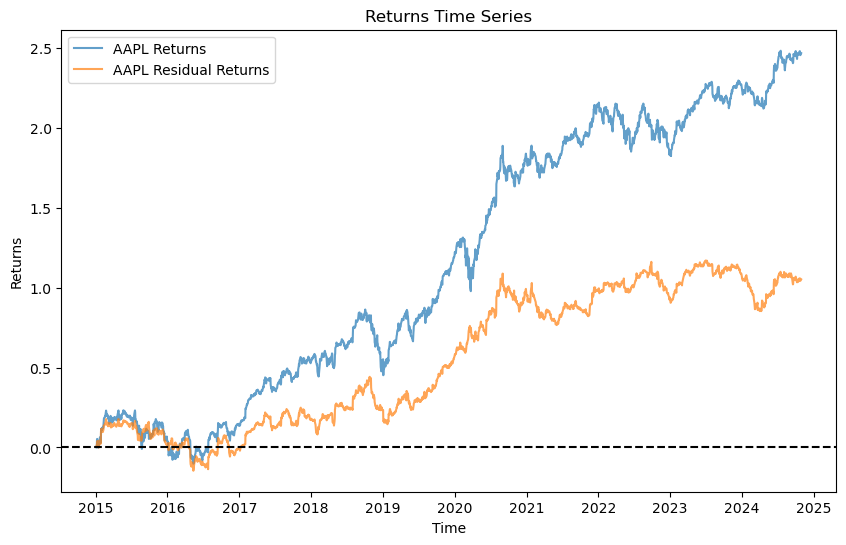

In [18]:
# Plot
ticker = 'AAPL'

# Create the Plot
plt.figure(figsize=(10, 6))
plt.plot(df_returns[ticker].cumsum(), label=f'{ticker} Returns', alpha=0.7)
plt.plot(alpha_resids_df[ticker].cumsum(), label=f'{ticker} Residual Returns', alpha=0.7)
plt.axhline(y=0, color='black', linestyle='dashed')

# Config
plt.title('Returns Time Series')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()

# Show
plt.show()

In [19]:
# Compare Volatility and Betas for each stock

anualized_vol = df_returns[ticker].std() * np.sqrt(252)
comparison = betas_series.loc[ticker]/anualized_vol

print(f'{ticker} Historical Beta is: {betas_series.loc[ticker]}')
print(f'{ticker} Historical Annualized Standard Deviation is: {anualized_vol}')
print(f'{ticker} Ratio Between Both is: {comparison}')

AAPL Historical Beta is: 1.19920570001144
AAPL Historical Annualized Standard Deviation is: 0.2858325099716254
AAPL Ratio Between Both is: 4.195483922141975


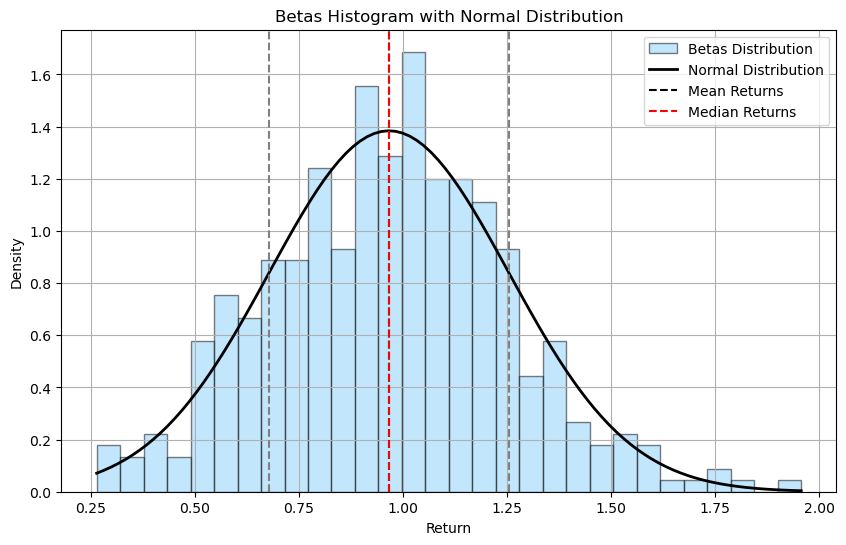

In [20]:
# Calculate Mean and Standard Deviation
mu = betas_series.mean()
sigma = betas_series.std()

# Create Histogram
plt.figure(figsize=(10, 6))
plt.hist(betas_series, bins=30, density=True, color='lightskyblue', alpha=0.5, edgecolor='black', label='Betas Distribution')

# Generate the Values of the Normal Distribution
x = np.linspace(betas_series.min(), betas_series.max(), 100)
y = norm.pdf(x, mu, sigma)

# Graph the Real Normal Distribution
plt.plot(x, y, color='black', linestyle='solid', linewidth=2, label='Normal Distribution')

# Reference Lines
plt.axvline(x=mu, color='black', linestyle='dashed', label='Mean Returns')
plt.axvline(x=betas_series.median(), color='red', linestyle='dashed', label='Median Returns')
plt.axvline(x=mu + sigma, color='grey', linestyle='dashed')
plt.axvline(x=mu - sigma, color='grey', linestyle='dashed')

# Config
plt.title('Betas Histogram with Normal Distribution')
plt.xlabel('Return')
plt.ylabel('Density')

# Legends and Grid
plt.legend()
plt.grid(True)

# Show
plt.show()